<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/06-Spatial_Data_and_Maps/A-Intro_to_Spatial_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Spatial Data: US census tracts and zipcodes

In [1]:
# @title Setup

!pip install -U -q geopandas tdqm folium mapclassify folium

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Change the graph defaults
plt.rcParams['figure.figsize'] = (8, 3)  # Default figure size of 6x2 inches
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['font.size'] = 10  # Default font size of 12 points
plt.rcParams['lines.linewidth'] = 1  # Default line width of 1 points
plt.rcParams['lines.markersize'] = 3  # Default marker size of 3 points
plt.rcParams['legend.fontsize'] = 10  # Default legend font size of 10 poin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 17.2 MB/s eta 0:00:00


,GEOID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,diff_geography
0,360610154009,36,061,015400,9,"POLYGON ((-73.95074 40.78326, -73.94982 40.782..."
1,360610066009,36,061,006600,9,"POLYGON ((-73.97862 40.74103, -73.97792 40.740..."
2,360610134009,36,061,013400,9,"POLYGON ((-73.95563 40.77186, -73.95365 40.771..."
3,360610138009,36,061,013800,9,"POLYGON ((-73.95729 40.77428, -73.95672 40.774..."
83,360610083001,36,061,008300,1,"POLYGON ((-74.00442 40.74228, -74.00156 40.741..."


## Types of Geographical Data and _Shapefiles_

When we deal with spatial data, we mainly deal with three general types of data:

* Points (e.g., lon/lat coordinates for a location)
* Lines (e.g., subway line)
* Polygons (e.g., borders of a country, state, zipcode etc)

From an analytics point of view, we are espeially interested in segmenting our data based on geography, and if possible also add additional information about the geographical area (e.g., population, average income etc).

There is a wide variety of geographical data available online. A big supplier of high-quality geographical data for the US is the US Census. They provide a complex geographical hierarchy, but at the basic level it is:

```
states > counties > tracts > blockgroups > blocks
```

The US Census tracts are roughly the size of zipcodes (in fact, a bit smaller, there are around 70K tracts and around 35K zipcodes in the US), and are a very common unit of statistical analysis. In fact, due to the carefulness in which US Census creates the tracts, to be as homogeneous as possible, it is a better geographical division that zipcodes.

## Examples of Geospatial Data offered by US Census

At data.gov you can find a [wide variety of geospatial data](https://catalog.data.gov/dataset/?metadata_type=geospatial). You may want to browse through some of the datasets.



## FIPS, States, and Counties

A good source of shapefiles for the US is the `TIGER` shapefiles offered by the US Census. For example, we can [get the shapes of all the US Counties](https://catalog.data.gov/dataset/tiger-line-shapefile-2019-nation-u-s-current-county-and-equivalent-national-shapefile).



In [ ]:
counties_url = 'https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip'
counties_df = gpd.GeoDataFrame.from_file(counties_url)

In [ ]:
counties_df = counties_df.filter ( ['GEOID', 'STATEFP', 'COUNTYFP', 'NAMELSAD', 'geometry'])

In [ ]:
# GEOID is the primary key for the county.
# It is a combination of the STATEFP + COUNTYFP
# The STATEFP and COUNTYFP are standardized at the federal level
# and can be used widely to refer to states and counties (and more
# fine grained entries)
counties_df

In [ ]:
# Dropping non-continental states
counties_df = counties_df.query( "STATEFP!='02'" )  # Alaska
counties_df = counties_df.query( "STATEFP!='15'" ) # Hawaii
counties_df = counties_df.query( "STATEFP!='72'" ) # Puerto Rico
counties_df = counties_df.query( "STATEFP!='66'" ) # Guam
counties_df = counties_df.query( "STATEFP!='69'" ) # Commonwealth of the Northern Mariana Islands
counties_df = counties_df.query( "STATEFP!='60'" ) # American Samoa
counties_df = counties_df.query( "STATEFP!='78'" ) # United States Virgin Islands

In [ ]:
# Let's visualize with a static plot

counties_df.plot(
    color = 'white',
    edgecolor = 'black',
    linewidth=0.1,
    zorder=0,
    facecolor = 'white',
)

In [ ]:
# Now let's visualize with an interactive plot
# We limit ourselves to three states, otherwise it takes too long to load
(
    counties_df
    .query("STATEFP == '36' or STATEFP == '42' or STATEFP == '34' ")
    .explore(
        "NAMELSAD", # We use the "NAMELSAD" to color the counties
        cmap='tab20', # We use a non-ordered color map, for categorical data
        legend=False,
        tiles='cartodbpositron',
        style_kwds=dict(color="black", linewidth=0.3)
    )
)

### Example: Plotting Walkability Scores

Let's now use an example dataset from the EPA, the "walkability index". The Walkability Index dataset characterizes every Census 2019 **block group** in the US based on its relative walkability.

The example below will illustrate a general pattern for creating _choropleths_, a specific type of map visualization, where we color each area of interest with a color, to visualize a quantity of interest; in this case, we will visualize the walkability scores.

In [27]:
# First, we fetch the walkability dataset from EPA
walk = pd.read_csv('https://edg.epa.gov/EPADataCommons/public/OA/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv')

# A bit of bookkeeping: Making sure that the STATEFP/COUNTYFP retain their leading zeros
# and are not converted to integers.
walk.STATEFP = walk.STATEFP.astype(str).str.zfill(2)
walk.COUNTYFP = walk.COUNTYFP.astype(str).str.zfill(3)
walk.TRACTCE = walk.TRACTCE.astype(str).str.zfill(6)
walk.BLKGRPCE = walk.BLKGRPCE.astype(str)

# Create a single-column primary key GEOID for each blockgroup
# instead of having a composite key with four attributes
walk['GEOID'] = walk.STATEFP.astype(str)  + walk.COUNTYFP.astype(str) + walk.TRACTCE.astype(str) + walk.BLKGRPCE.astype(str)

# We make it easier to select counties based on a single column FIPS code instead of
# having separately STATEFP and COUNTYFP
walk['COUNTY_GEOID'] = walk.STATEFP.astype(str)  + walk.COUNTYFP.astype(str)

# Keep only a few of the columns in the dataset, we do not need the rest for this exercise
walk = walk.filter ( ['GEOID', 'COUNTY_GEOID', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'NatWalkInd'])

In [ ]:
# Let's visualize the walkability score distribution across all 220K blockgroups
walk.NatWalkInd.hist(bins=115)

### Aggregate walkability scores on the county level

We have the data on a blockgroup level, but we want to calculate the score for counties. So we aggregate the scores across all blockgroups in a county.

In [ ]:
# Now, let's calculate the average walkability score for each county.
# We will average across all blockgroups in that county.

county_walk_scores_mean = walk.pivot_table(
    index = 'COUNTY_GEOID',
    values = 'NatWalkInd',
    aggfunc = 'mean' #
)

county_walk_scores_mean

In [ ]:
# @title (Optional) Alternative aggregation functions: Max & Mean of top-10%


county_walk_scores_max = walk.pivot_table(
    index = 'COUNTY_GEOID',
    values = 'NatWalkInd',
    aggfunc = 'max' # If we want to score each county based on its best score
)

# Calculates the mean across the top-10%
def top_10_percent_avg(series):
    threshold = np.ceil(len(series) * 0.1)  # Compute the number of entries for top 10%
    top_10_percent = series.nlargest(int(threshold))  # Get the top 10% values
    return top_10_percent.mean()  # Return their mean

county_walk_scores_mean10perc = walk.pivot_table(
    index = 'COUNTY_GEOID',
    values = 'NatWalkInd',
    aggfunc = top_10_percent_avg # Finds the top-10% of the blockgroups and calculates their average score
)

### Putting data together

In [ ]:
# We now join the "geodataframe" counties_df, which contains the the shapes/geometries
# with the "walkability scores" and we keep at the end only the attributes that we need
gdf_scores = pd.merge(
    left = counties_df, # The geodataframe with the county shapes
    right = county_walk_scores_mean, # The walkability scores per county
    left_on="GEOID", # The id for the county in the geodataframe is GEOID
    right_index=True # The county code in the pivot table is in the index
).filter( ['GEOID', 'STATEFP', 'NAMELSAD',  'NatWalkInd', 'geometry']) # Keep only

gdf_scores

In [ ]:
# Let's see the most walkable counties (on average)
gdf_scores.sort_values('NatWalkInd', ascending=False).head(10)

In [ ]:
gdf_scores.plot(
    column = 'NatWalkInd', # Defines what column we will use for the visualization
    legend = True,
    cmap = 'RdYlGn', # This defines the color scheme
    edgecolor = 'black',
    linewidth=0.1,
)

In [ ]:
# When we use color scales to visualize a quantity, we often do not use the
# color space effectively, when the distribution of values is skewed.
# So, in many cases we covert the quantity into "percentiles" (or ranks)
# that are guaranteed to be uniformly distributed and allow all colors
# of the color scheme to be shown in the visualization.
gdf_scores["NatWalkInd_percentile"] = gdf_scores['NatWalkInd'].rank(pct=True)

gdf_scores.plot(
    column = 'NatWalkInd_percentile',
    legend = True,
    cmap = 'RdYlGn',
    edgecolor = 'black',
    linewidth=0.1,
)

In [ ]:
# Let's visualize with an interactive plot
(
    gdf_scores
    .query("STATEFP == '36' or STATEFP == '42' or STATEFP == '34' ")
    .explore(
        "NatWalkInd",
        cmap='RdYlGn',
        legend=False,
        tiles='cartodbpositron',
        style_kwds=dict(color="black", linewidth=0.3)
        )
)

In [50]:
# @title Retrieving shapefiles for blockgroups from Google Bigquery

from google.cloud import bigquery
from google.colab import auth
from shapely import wkt
import geopandas as gpd

auth.authenticate_user()

# Put your own Google Cloud project id below
# I just named my project "query-bigquery"
client = bigquery.Client(project='query-bigquery')

# Get the shapefiles for blockgroups for Manhattan
# STATEFP = '36' is New York State and
# COUNTYFP = '061' is Manhattan county
query = """
SELECT GEOID,	diff_geography AS geometry
FROM `nyu-datasets.shapefiles.us_blockgroups_nowater`
WHERE STATEFP = '36' and COUNTYFP = '061'
"""

# Run the query and convert it to a GeoDataFrame
gdf = client.query(query).to_geodataframe()
# Remove "empty" geometries (note that these are not NULL)
gdf = gdf[~gdf['geometry'].is_empty]

# Display the first few rows of the DataFrame.
gdf.head()

,GEOID,geometry
0,360610220003,"POLYGON ((-73.95281 40.80587, -73.95217 40.805..."
1,360610146013,"POLYGON ((-73.95494 40.7775, -73.9527 40.77656..."
2,360610044005,"POLYGON ((-73.97131 40.72734, -73.97128 40.727..."
3,360610132007,"POLYGON ((-73.94797 40.76951, -73.9482 40.7695..."
4,360610148021,"POLYGON ((-73.95418 40.78143, -73.95258 40.780..."


<Axes: >

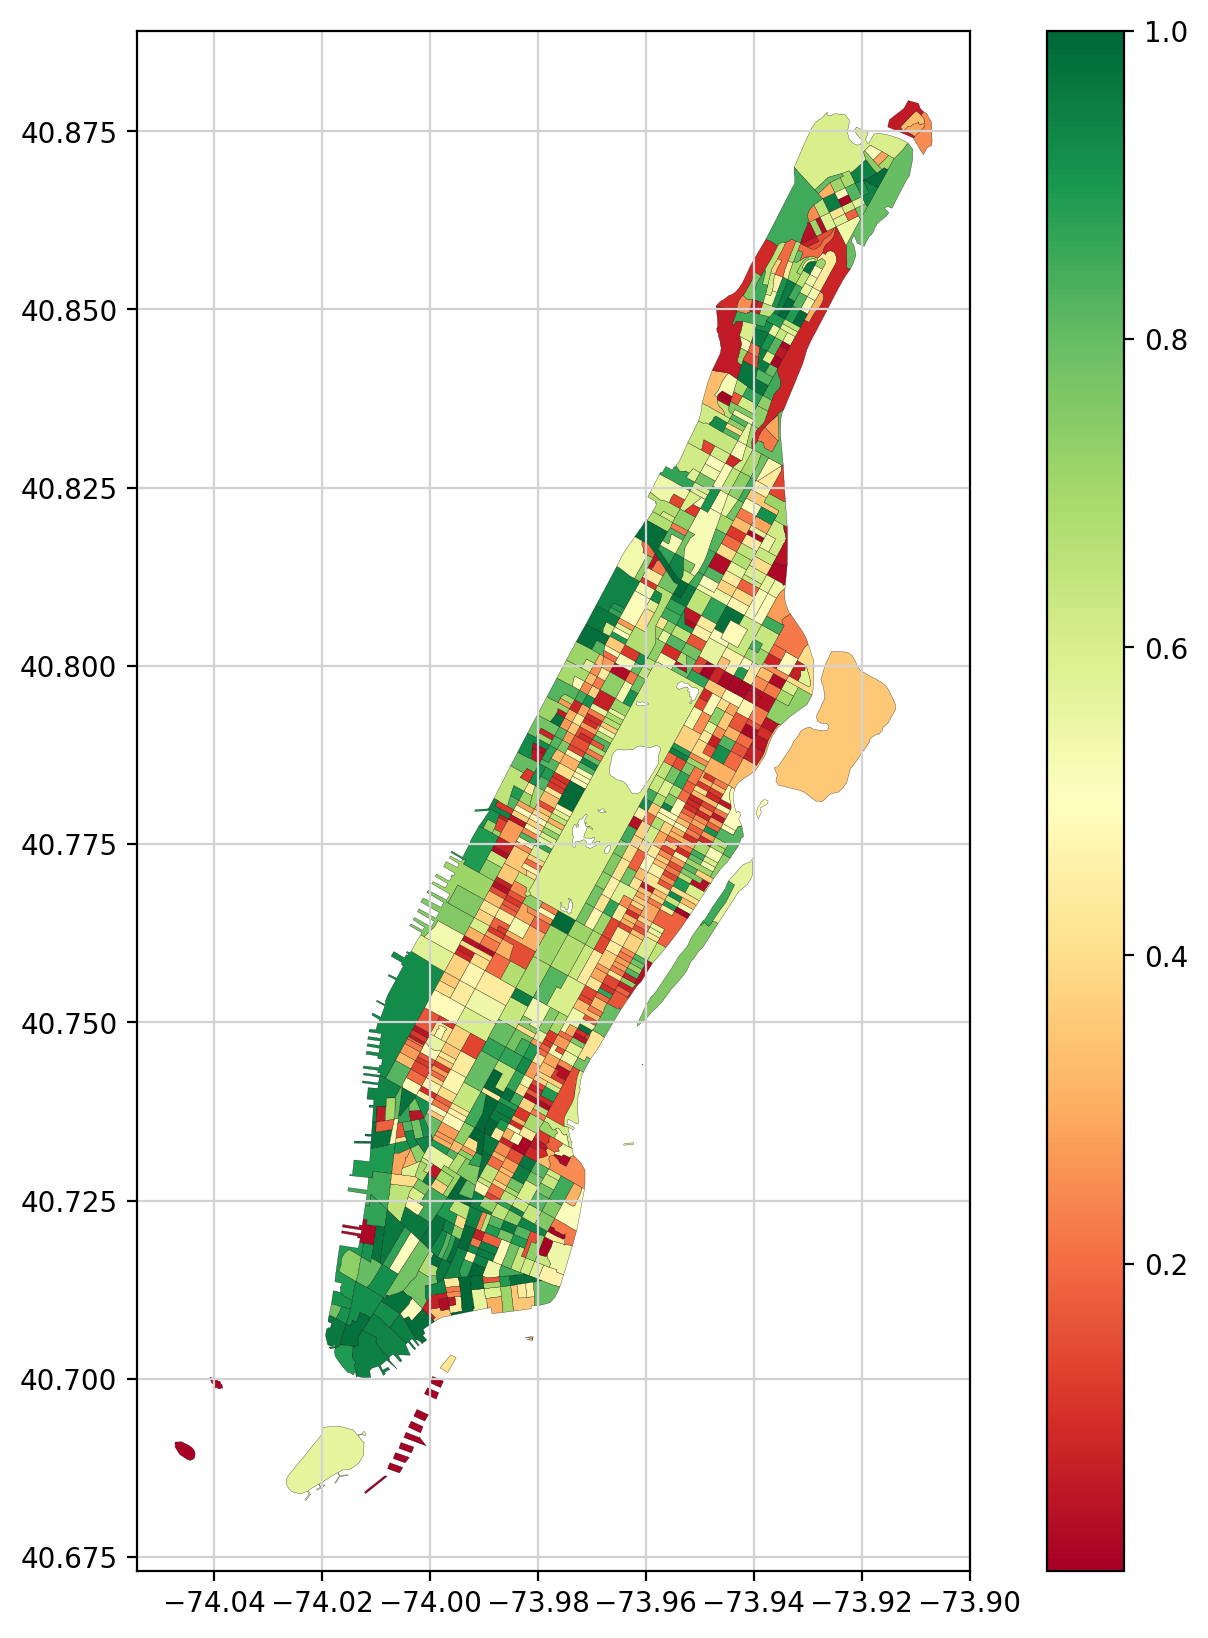

In [52]:
# We now join the "geodataframe" gdf, which contains the the shapes/geometries for the blockgroups
# with the "walkability scores" and we keep at the end only the attributes that we need
gdf_scores = pd.merge(
    left = gdf, # The geodataframe with the shapes for the blockgroups
    right = walk, # The walkability scores per blockgroup
    on="GEOID", # The id for the blockgroup
).filter( ['GEOID', 'NatWalkInd', 'geometry'])

# Create a normalized version of the walkability scores, within Manhattan
gdf_scores["NatWalkInd_percentile"] = gdf_scores['NatWalkInd'].rank(pct=True)

gdf_scores.plot(
    column = 'NatWalkInd_percentile', # Defines what column we will use for the visualization
    legend = True,
    cmap = 'RdYlGn', # This defines the color scheme
    edgecolor = 'black',
    linewidth=0.1, figsize=(10,10)
)



In [55]:
# And the interactive version
gdf_scores.explore(
        "NatWalkInd_percentile",
        cmap='RdYlGn',
        legend=True,
        tiles='CartoDB positron',
        style_kwds={
        'color': 'black',  # Border color
        'weight': 0.5,  # Border thickness (make it thinner)
        'fillOpacity': 0.8  # Increase fill opacity for more saturated colors
    }
        )

## US Census Tracts




The US Census runs a yearly survey (the ACS survey) that collects a wide variety of detailed information about each census tract. [For example, consider the information about our own census tract](https://censusreporter.org/profiles/14000US36061005501-census-tract-5501-new-york-ny/): data about population, income, age, educational level, house values, renters vs owners, and many many other data points.

The file below contains the description of all the US Census tracts:

In [ ]:
!curl https://storage.googleapis.com/datasets_nyu/usa_tracts.zip -o usa_tracts.zip

In [ ]:
shapefile = f'usa_tracts.zip'
tracts_df = gpd.GeoDataFrame.from_file(shapefile)

# makes it easier to select counties based on their FIPS code
tracts_df.COUNTYFP = tracts_df.STATEFP.astype(str)  + tracts_df.COUNTYFP.astype(str)

In [ ]:
tracts_df

In [ ]:
# Dropping non-continental states
tracts_df = tracts_df[ tracts_df.STATEFP!='02' ]  # Alaska
tracts_df = tracts_df[ tracts_df.STATEFP!='15' ] # Hawaii
tracts_df = tracts_df[ tracts_df.STATEFP!='72' ] # Puerto Rico
tracts_df = tracts_df[ tracts_df.STATEFP!='66' ] # Guam
tracts_df = tracts_df[ tracts_df.STATEFP!='69' ] # Commonwealth of the Northern Mariana Islands
tracts_df = tracts_df[ tracts_df.STATEFP!='60' ] # American Samoa
tracts_df = tracts_df[ tracts_df.STATEFP!='78' ] # United States Virgin Islands

In [ ]:
tracts_df.plot(
    color = 'white',
    edgecolor = 'black',
    linewidth=0.1,
    zorder=0,
    facecolor = 'white',
)

## ZIP Codes

Often people ask why we do not use zipcodes instead of census tracts.

The answer is two-fold:

* The USPS does not release shapefiles of their zipcodes
* [The zip codes are not areas](https://manifold.net/doc/mfd9/zip_codes_are_not_areas.htm). In fact they are a bunch of delivery routes/lines, not areas.
* The US Census though releases the [ZIP Code Tabulation Areas (ZCTAs)](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html)



In [ ]:
!curl https://storage.googleapis.com/datasets_nyu/tl_2020_us_zcta510.zip -o tl_2020_us_zcta510.zip

In [ ]:
shapefile = f'tl_2020_us_zcta510.zip'
zipcodes_df = gpd.GeoDataFrame.from_file(shapefile)


In [ ]:
zipcodes_df

In [ ]:
zipcodes_df.plot(
    figsize=(20,20),
    color = 'white',
    edgecolor = 'black',
    linewidth=0.1,
    zorder=0,
    facecolor = 'white',
)